# WASP-127: Fitting multiple LCs

In [3]:
from glob import glob
from os.path import basename

import numpy as np
import CONAN
import matplotlib.pyplot as plt
import pandas as pd
CONAN.__version__

'3.3.12'

The CONAN has 3 major classes that are used to store information about the input files and also perform computations.

They are:
- `load_lightcurves()` : ingest lightcurve files and creates an object that is used to configure baseline and model parameters. It contains methods to configure the LCs for fitting    
- `load_rvs()` : same as above but for rvs
- `fit_setup()` : object to setup sampling of the parameter space

These objects are then given as input to the `run_fit()` function to perform sampling. 

## Setup light curve object

In [2]:
path = "../data/"    #path to the lightcurve files

lc_list  = sorted(glob(f"{path}*bjd.dat"))   #select euler lightcurves
lc_list = [basename(lc) for lc in lc_list]
lc_list

['lc1bjd.dat',
 'lc2bjd.dat',
 'lc3bjd.dat',
 'lc4bjd.dat',
 'lc5bjd.dat',
 'lc6bjd.dat',
 'lc7bjd.dat']

### load light curve into CONAN and visualize

In [3]:
lc_obj = CONAN.load_lightcurves( file_list     = lc_list,
                                  data_filepath = path,
                                  filters       = ["R"],
                                  nplanet       = 1)
lc_obj

# ============ Input lightcurves, filters baseline function =======================================================
name       flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc1bjd.dat R   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    1 n  None           
lc2bjd.dat R   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    2 n  None           
lc3bjd.dat R   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    3 n  None           
lc4bjd.dat R   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    4 n  None           
lc5bjd.dat R   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    5 n  None           
lc6bjd.dat R   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    6 n  None           
lc7bjd.dat R   0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    7

lightcurves from filepath: ../data/
1 transiting planet(s)
Order of unique filters: ['R']

- **The lightcurve object** `lc_obj` holds information about the light curves (data and settings).

By default they are all deactivated. We will define the ones relevant options for this notebook


`clip`: outlier clipping

`scl_col`: scaling the arrays in the columns of the data

`col{x}`: polynomial order in the columns x={0,3,4,5,6,7} of the data to  use for decorrelation


##### Visualizing the data

The light curves can be plotted using the `plot()` method of the object.

By default this plots column 0 (time) against column 1 (flux) with column 3(flux err) as uncertainties. 

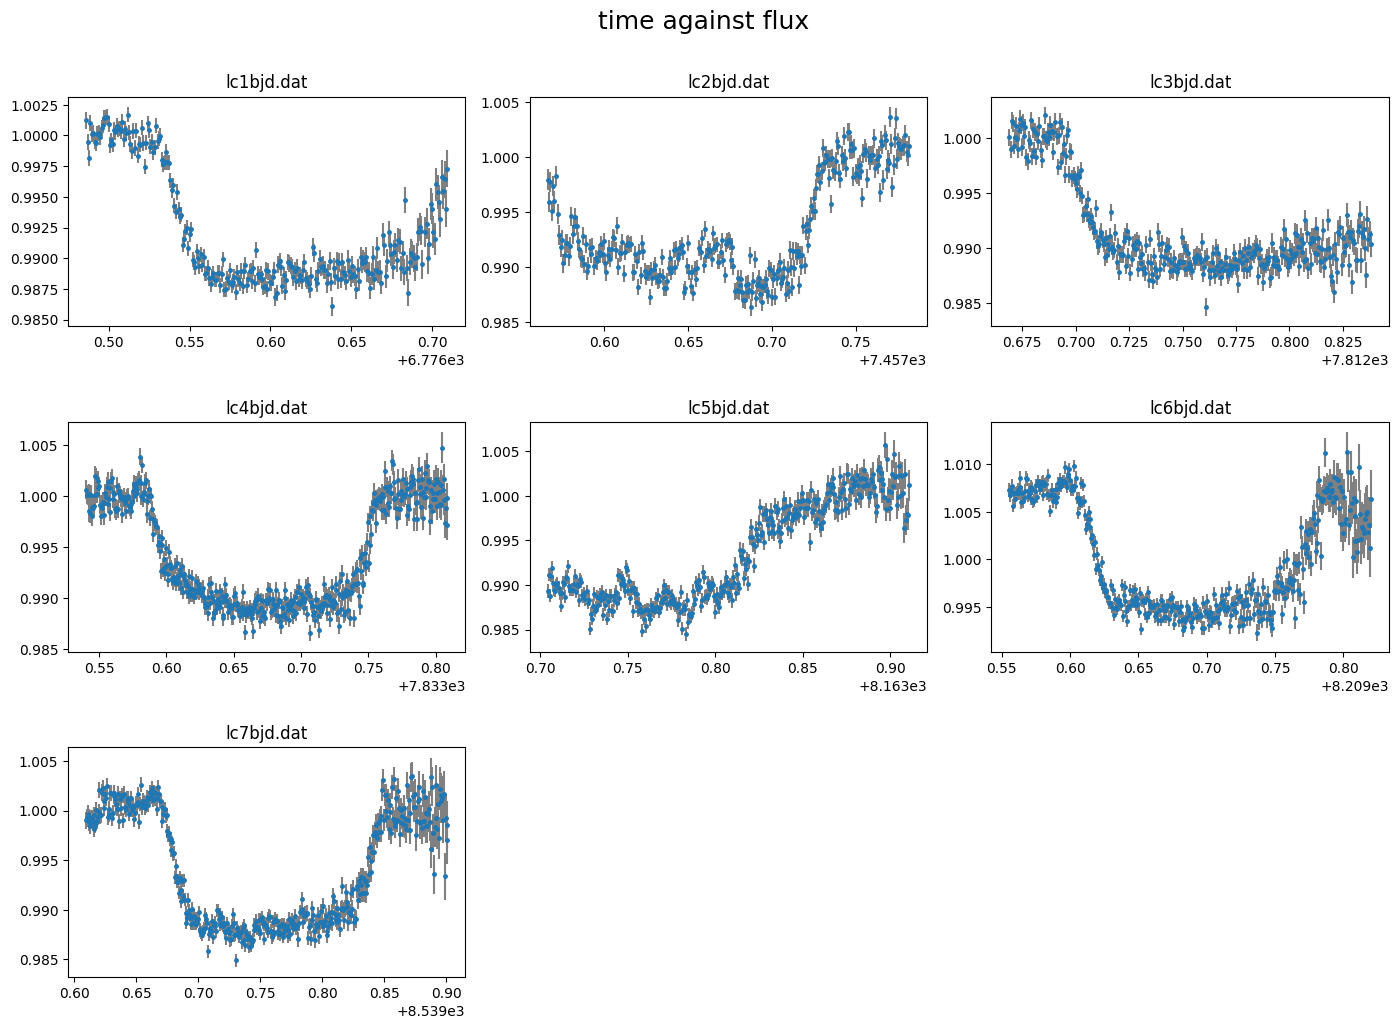

In [4]:
lc_obj.plot()

- **correlations** between the flux and other columns in the lightcurve file can be visualized by specifying the columns to plot. e.g. to plot column5 against column 1 (flux)

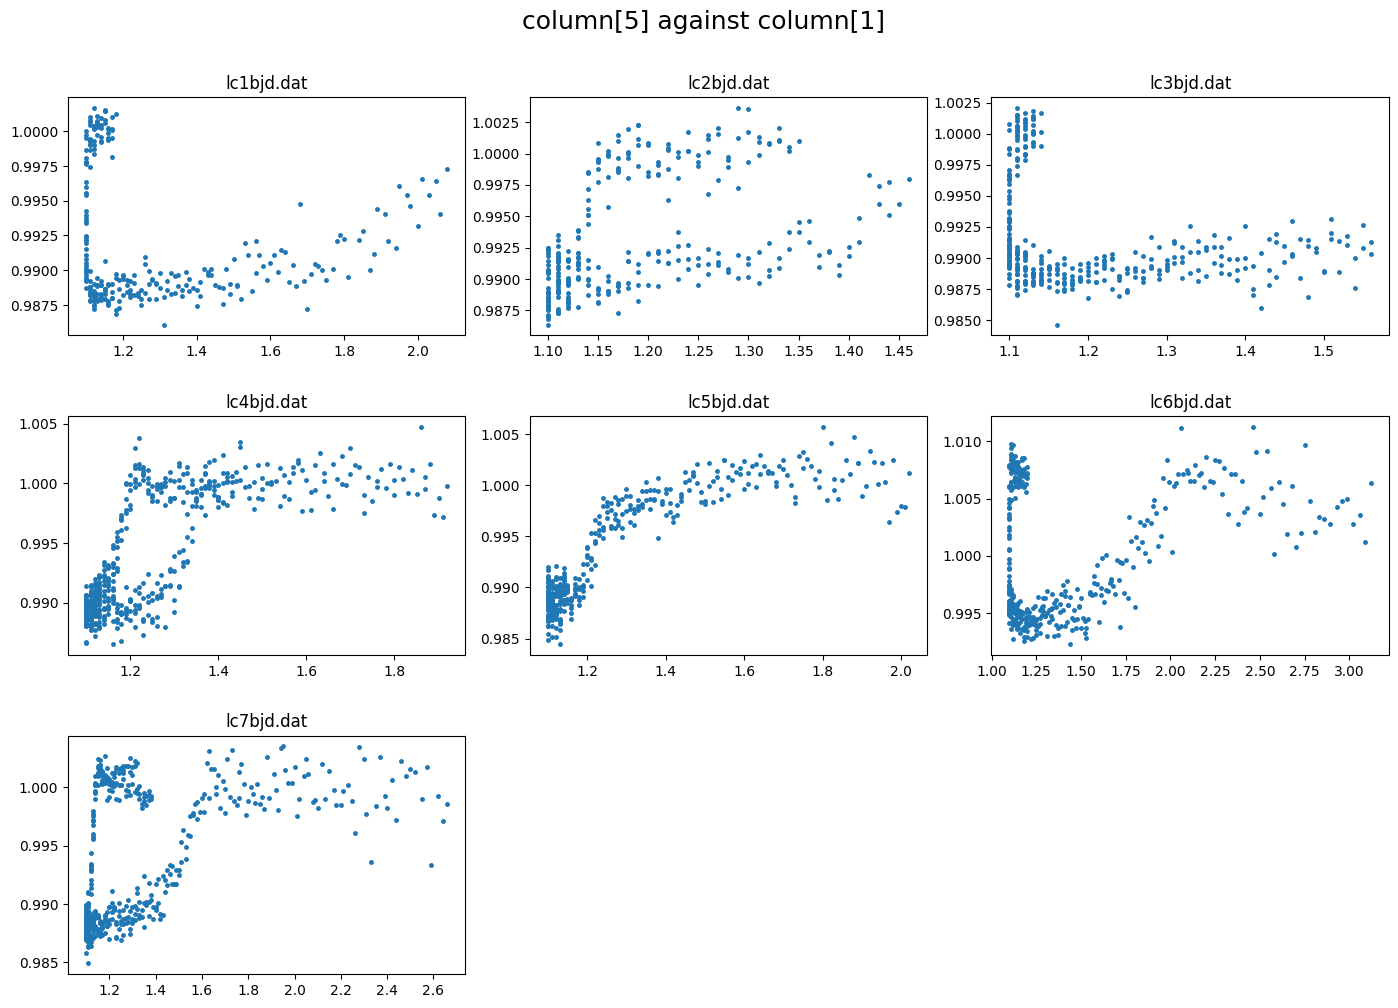

In [5]:
lc_obj.plot(plot_cols=(5,1))

### some data processing

##### clipping outlier points

 we can remove outliers from all or specific lcs. This uses a sliding median of specified `width` to discard points greater than `clip`$\times$ the M.A.D (median absoulte deviation). The clipped data is saved to the `lc_obj` further analysis is performed on the clipped data

In [ ]:
lc_obj.clip_outliers(lc_list="all", width=11, clip=4)

##### rescaling data columns. 

This is useful for decorrelating the flux against the different columns. It is only performed on columns 3 and above whose values do not span zero. There are 3 methods to rescale the data: **"med_sub"**, **"rs0to1"**, **"rs-1to1"** which subtracts the median, rescales to [0-1], or rescales to [-1,1] respectively


In [7]:
lc_obj.rescale_data_columns(method="med_sub")

Rescaled data columns of lc1bjd.dat with method:med_sub
Rescaled data columns of lc2bjd.dat with method:med_sub
Rescaled data columns of lc3bjd.dat with method:med_sub
Rescaled data columns of lc4bjd.dat with method:med_sub
Rescaled data columns of lc5bjd.dat with method:med_sub
Rescaled data columns of lc6bjd.dat with method:med_sub
Rescaled data columns of lc7bjd.dat with method:med_sub


### Setup Transit 

Parameters are defined in `CONAN` in 3 formats:
- **Fixed**:          int/float e.g `q1` = 0.5
- **Uniform prior**:  tuple of length 3 --> (min, start, max) e.g. `Period` = (0, 0.5, 1) 
- **Normal prior**:   tuple of length 2 --> (mean, sigma) e.g. `rho_star` = (0.5, 0.03)


##### system parameters

We can get **system parameters** from the [NASA exoplanet archive](https://exoplanetarchive.ipac.caltech.edu/)

In [4]:
from CONAN.get_files import get_parameters

sys_params = get_parameters(planet_name="WASP-127b") #result cached in the current working directory
sys_params

Loading parameters from cache ...


{'star': {'Teff': (5620.0, 85.0),
  'logg': (4.18, 0.01),
  'FeH': (-0.193, 0.014),
  'radius': (1.333, 0.027),
  'mass': (0.95, 0.02),
  'density': (0.569, 0.021)},
 'planet': {'name': 'WASP-127 b',
  'period': (4.17806203, 8.8e-07),
  'rprs': (0.10103, 0.00026),
  'mass': (0.1647, 0.0214),
  'ecc': (0.0, nan),
  'w': (nan, nan),
  'T0': (2456776.62124, 0.00023),
  'b': (0.29, 0.04),
  'T14': (0.18137, 0.00035),
  'aR': (7.81, 0.11),
  'K[m/s]': (22.0, 3.0)}}

##### Transit and RV

The `sys_params` can be used to specify the priors for the planet's **transit and RV** parameters

Let's put the planet parameters in a dictionary for convenience. The parameters are defined for **transit/occultation/phasecurve/rv**


In [9]:
t0  = sys_params["planet"]["T0"][0] - 2450000

planet_pars = dict( T_0           = (t0, 0.001),                            # normal prior
                    Period        = sys_params["planet"]["period"][0],      # fixed
                    rho_star      = sys_params["star"]["density"],          # normal pripr
                    Impact_para   = (0, sys_params["planet"]["b"][0], 1),   # uniform prior
                    RpRs          = (0.05, 0.102, 0.17),                    # uniform prior
                    Eccentricity  = 0,                                      # fixed
                    omega         = 90,
                    K             = 0)

The `.planet_parameters()` method of `lc_obj` is called to define the parameters in `CONAN`. 
This method takes in the same parameter names as defined in `planet_pars` dictionary so we can load this directly

In [10]:
lc_obj.planet_parameters(**planet_pars)

# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                              	note
[rho_star]/Duration        y   	N(0.569,0.021)                     	#choice in []|unit(gcm^-3/days)
--------repeat this line & params below for multisystem, adding '_planet_number' to the names e.g RpRs_1 for planet 1, ...
RpRs                       y   	U(0.05,0.102,0.17)                 	#range[-0.5,0.5]
Impact_para                y   	U(0,0.29,1)                        	#range[0,2]
T_0                        y   	N(6776.621239999775,0.001)         	#unit(days)
Period                     n   	F(4.17806203)                      	#range[0,inf]days
[Eccentricity]/sesinw      n   	F(0)                               	#choice in []|range[0,1]/range[-1,1]
[omega]/secosw             n   	F(90)                              	#choice in []|range[0,360]deg/range[-1,1]
K                          n   	F(0)      

##### Limb darkening

- The `sys_params` can also be used to obtain priors on the **stellar limb darkening** from the phoenix stellar library.
`CONAN` uses the Kipping parameterization of the quadratic law defined as $q_1$ and $q_2$.


Filter names can be obtained from the [SVO filter service](http://svo2.cab.inta-csic.es/theory/fps/) with names such as `Spitzer/IRAC.I1` or a name shortcut such as `TESS`, `CHEOPS`,`kepler`. 


List of filter shortcut names can be obtained using:

In [11]:
lc_obj._filter_shortcuts

{'kepler': 'Kepler/Kepler.k',
 'tess': 'TESS/TESS.Red',
 'cheops': 'CHEOPS/CHEOPS.band',
 'wfc3_g141': 'HST/WFC3_IR.G141',
 'wfc3_g102': 'HST/WFC3_IR.G102',
 'sp36': 'Spitzer/IRAC.I1',
 'sp45': 'Spitzer/IRAC.I2',
 'ug': 'Geneva/Geneva.U',
 'b1': 'Geneva/Geneva.B1',
 'b2': 'Geneva/Geneva.B2',
 'bg': 'Geneva/Geneva.B',
 'gg': 'Geneva/Geneva.G',
 'v1': 'Geneva/Geneva.V2',
 'vg': 'Geneva/Geneva.V',
 'sdss_g': 'SLOAN/SDSS.g',
 'sdss_r': 'SLOAN/SDSS.r',
 'sdss_i': 'SLOAN/SDSS.i',
 'sdss_z': 'SLOAN/SDSS.z'}

specify a filter for the EULER

In [12]:
filts = ['sdss_r']

In [13]:
print(f"\nGetting limb darkening parameters for filter {filts}")
q1, q2 = lc_obj.get_LDs( Teff = sys_params['star']['Teff'],
                        logg  = sys_params['star']['logg'],
                        Z     = sys_params['star']['FeH'],
                        filter_names=filts,
                        # fixed_unc=0.02   #use uncertainty of 0.02 for all q1 and q2 values
            )



Getting limb darkening parameters for filter ['sdss_r']
sdss_r    (R): q1=(0.4221, 0.0197), q2=(0.3961, 0.0129)


 `q1`, `q2`  can then be passed to the `.limb_darkening()` method of `lc_obj`

In [14]:
lc_obj.limb_darkening(q1=q1, q2=q2)

# ============ Limb darkening setup ============================================================================= 
filters	fit	q1               	q2               
R      	y  	N(0.4221,0.0197) 	N(0.3961,0.0129) 


### Baseline and decorrelation parameters

The **baseline model** for each lightcurve in `lc_obj` object can be defined **manually** or **automagically**

##### Manually define baseline model:

We manually define the baseline model using the `.lc_baseline()` method of the `lc_obj`

Define baseline model parameters to fit for each light curve using the columns of the input data. `dcol0` refers to decorrelation setup for column 0, `dcol3` for column 3, and so on.

Each baseline decorrelation parameter (dcol{x}) should be a list of integers specifying the polynomial order for column {x} for each light curve. e.g. Given 2 input light curves as we have here, 

If one wishes to fit a 1st order trend in column 0 (time) to all lightcurves, then `dcol0` = 1. This creates a so we have `lc{n}_A0`, where {n} goes from 1 to the number of loaded lightcurves, and `A0` depicts first order in column 0.

For most of the input lightcurves, we saw a strong correlation of the flux with column 5. We can fit this with a 2nd order term by setting `dcol5` = 2. this creates `lc{n}_A5` and  `lc{n}_B5`, as second order fit `B5` necessarily includes the first oder `A5`.

In [15]:
lc_obj.lc_baseline( dcol0 = 1, 
                    dcol5 = 2)

# ============ Input lightcurves, filters baseline function =======================================================
name       flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc1bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    1    0    0    2    0    0    0|n    1 n  None           
lc2bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    1    0    0    2    0    0    0|n    2 n  None           
lc3bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    1    0    0    2    0    0    0|n    3 n  None           
lc4bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    1    0    0    2    0    0    0|n    4 n  None           
lc5bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    1    0    0    2    0    0    0|n    5 n  None           
lc6bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    1    0    0    2    0    0    0|n    6 n  None           
lc7bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    1    0    0    2    0    0    0|n    7

There's no guarantee this is the optimal baseline model. The `.get_decorr()` function of the `lc_obj` can be used to automatically determine the best decorrelation parameters to use.

To do this, we would like take into account the transit/occultation when peforming the least-squares fit. So the defined transit parameter priors in `planet_pars` are also used


getting decorr params for lc01: lc1bjd.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:378.98, pars:['offset', 'A6', 'A4']

getting decorr params for lc02: lc2bjd.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:549.14, pars:['offset', 'A6', 'A0', 'B7']

getting decorr params for lc03: lc3bjd.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:562.80, pars:['offset', 'A6', 'A7']

getting decorr params for lc04: lc4bjd.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:706.68, pars:['offset', 'A6']

getting decorr params for lc05: lc5bjd.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:756.34, pars:['offset', 'B0', 'A6', 'B3', 'B5']

getting decorr params for lc06: lc6bjd.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:678.02, pars:['offset', 'A6', 'B5', 'A5']

getting decorr params for lc07: lc7bjd.dat (spline=False, sine=

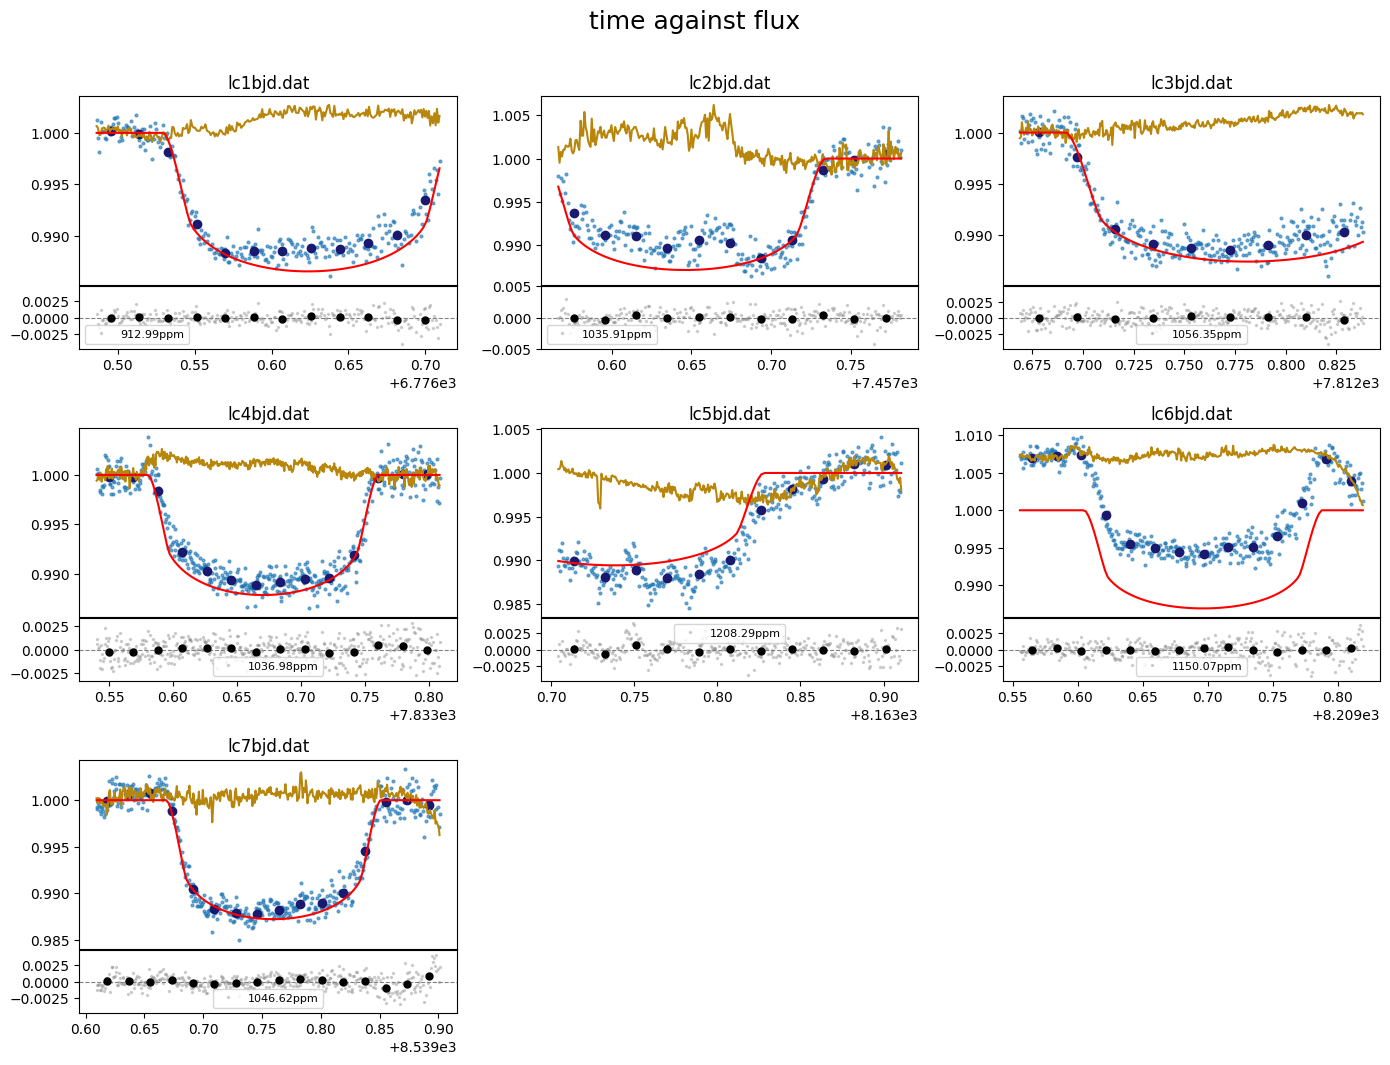

In [16]:
decorr_res = lc_obj.get_decorr( **planet_pars,
                                q1 = q1,    q2 = q2,
                                delta_BIC      = -5, 
                                exclude_cols   = [8], #exclude this column(exptime)
                                setup_baseline = True
                                )

the output `decorr_res` is a list that holds the `lmfit` result for each lc.

By specifying `use_result=True` in the function call above, several other lightcurve configuration (*baseline*, *gp*, *transit&RV* parameters, *phase curve*, *limb darkening*) that uses the same inputs have been automatically set up

We can use the `.plot()` method again to visualize the fit quality across the different decorrelation axis by setting `show_decorr_model=True`

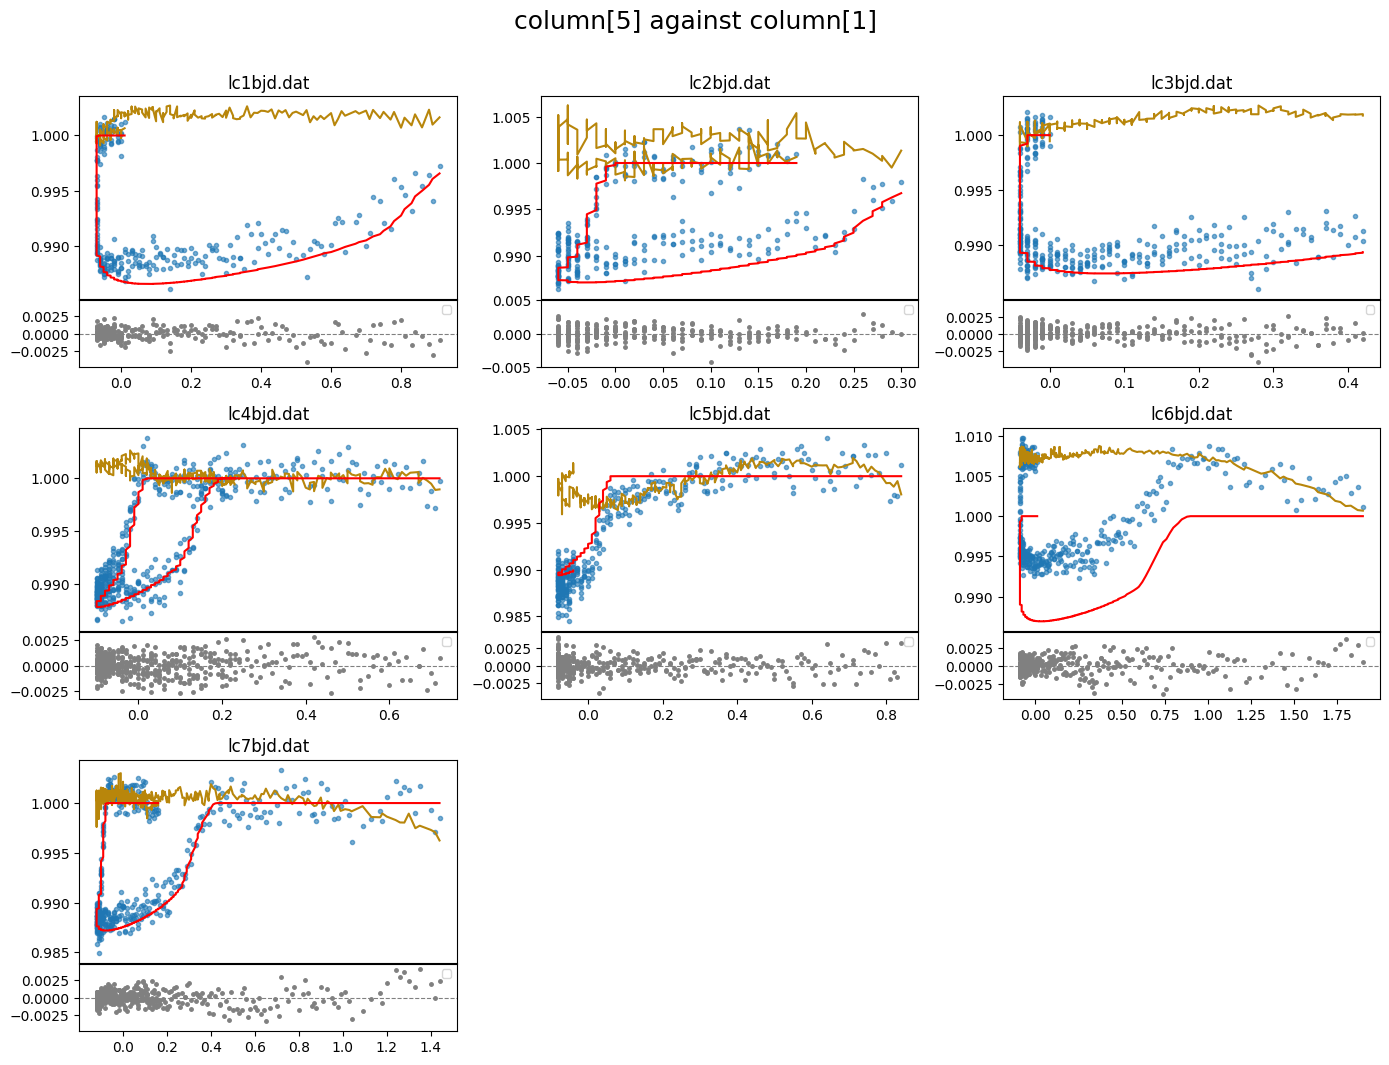

In [17]:
lc_obj.plot(plot_cols=(5,1), show_decorr_model=True)

We can use the `.print()` method to print out the current configuration of the different sections of the `lc_obj`

To see the current baseline model configuration, set section to "lc_baseline"

In [18]:
lc_obj.print(section="lc_baseline")

# ============ Input lightcurves, filters baseline function =======================================================
name       flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
lc1bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    0    0    1    0    1    0    0|n    1 n  None           
lc2bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    1    0    0    0    1    2    0|n    2 n  None           
lc3bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    0    0    0    0    1    1    0|n    3 n  None           
lc4bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    0    0    0    0    1    0    0|n    4 n  None           
lc5bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    2    2    0    2    1    0    0|n    5 n  None           
lc6bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    0    0    0    2    1    0    0|n    6 n  None           
lc7bjd.dat R   0.6  |None c1:W11C4n1   med_sub |  y    0    0    0    2    1    0    0|n    7

## Setup Sampling

finally to setup the `fit_obj` which is used to configure the fitting.

We can specify values for the stellar mass or radius to be used to convert parameter results to physical values. These values are not used in the fit, only for the post-fit conversion. We can also take the values from our NASA archive `sys_params` dictionary

In [19]:
sys_params["star"]["radius"], sys_params["star"]["mass"]

((1.333, 0.027), (0.95, 0.02))

In [5]:
fit_obj = CONAN.fit_setup(  R_st      = sys_params["star"]["radius"],
                            M_st      = sys_params["star"]["mass"],
                            par_input = "Rrho",
                          )

# ============ Stellar input properties ======================================================================
# parameter     value 
Radius_[Rsun]  N(1.333,0.027)
Mass_[Msun]    N(0.95,0.02)
Input_method:[R+rho(Rrho), M+rho(Mrho)]: Rrho


setup sampling using the `.sampling()` method of `fit_obj`. Note that the sampling of the parameter space can be done with `emcee` or `dynesty`

In [6]:
fit_obj.sampling(sampler="dynesty",n_cpus = 10, n_live=300)

# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    300 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n,list)                  y 
apply_RVjitter(y/n,list)                  y 
LCjitter_loglims(auto/[lo,hi])            auto 
RVjitter_lims(auto/[lo,hi])               auto 
LCbasecoeff_lims(auto/[lo,hi])            auto 
RVbasecoeff_lims(auto/[lo,hi])            auto 
Light_Travel_Time_correction(y/n)         n 
apply_LC_GPndim_jitter(y/n)        

## export configuration file

In [ ]:
CONAN.create_configfile(lc_obj  = lc_obj, 
                         rv_obj  = None, 
                         fit_obj = fit_obj,
                         filename='wasp127_euler_config.dat')

load_rvs(): loading RVs from path - /Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN/Notebooks/WASP-127/WASP-127_EULER_LC/
Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.
configuration file saved as wasp127_euler_config.dat


In [1]:
import CONAN
lc_obj, rv_obj, fit_obj = CONAN.load_configfile(configfile='wasp127_euler_config.dat')

load_lightcurves(): loading lightcurves from path -  /Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN/Notebooks/WASP-127/WASP-127_EULER_LC/../data/
load_rvs(): loading RVs from path - /Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN/Notebooks/WASP-127/WASP-127_EULER_LC/


## Sampling

Finally perform the **fitting** which returns a result object `result_obj` that holds the chains from the sampling and allows subsequent plotting.

The result of the fit is saved to a user-defined folder (default = 'output'). If a fit result already exists in this folder, it is loaded to the `result_obj`

In [ ]:
result = CONAN.run_fit(lc_obj  = lc_obj,
                        rv_obj  = None,
                        fit_obj = fit_obj,
                        out_folder="result_wasp127_euler",
                        rerun_result=True);

 - The **summary statistics** of the fitted and derived parameters are written as **result_*.dat** files in the output folder. 


## results

In [1]:
import CONAN
import matplotlib.pyplot as plt
import numpy as np
from CONAN.utils import bin_data, phase_fold

In [4]:
result =CONAN.load_result(folder="result_wasp127_euler")

['lc'] Output files, ['lc1bjd_lcout.dat', 'lc2bjd_lcout.dat', 'lc3bjd_lcout.dat', 'lc4bjd_lcout.dat', 'lc5bjd_lcout.dat', 'lc6bjd_lcout.dat', 'lc7bjd_lcout.dat'], loaded into result object
['rv'] Output files, [], loaded into result object


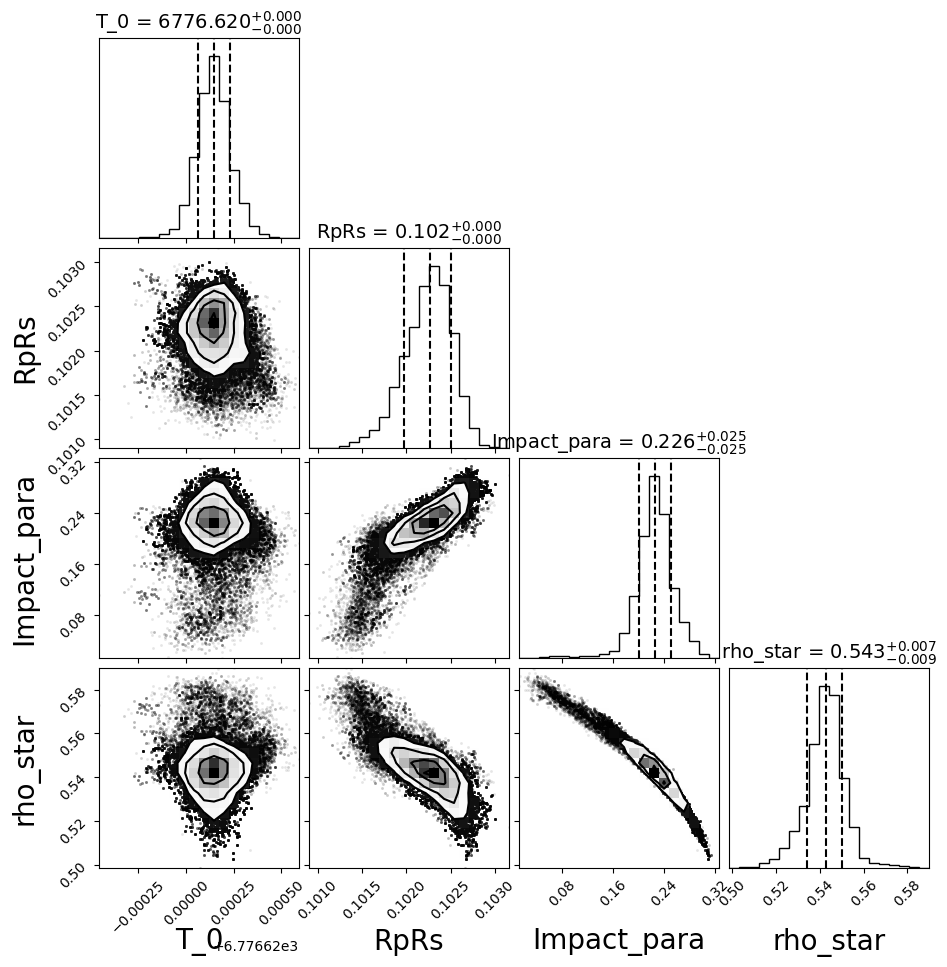

In [5]:
fig = result.plot_corner(pars = ['T_0', 'RpRs', 'Impact_para', 'rho_star']);

### make output file for max posterior values

the output files are generated from the median posterior values. The user can create output models from the maximum posterior

In [6]:
result.make_output_file("max", 
                        out_folder="result_wasp127_euler/max_out_data")

    - Writing LC output to file: result_wasp127_euler/max_out_data/out_data/lc1bjd_lcout.dat
    - Writing LC output to file: result_wasp127_euler/max_out_data/out_data/lc2bjd_lcout.dat
    - Writing LC output to file: result_wasp127_euler/max_out_data/out_data/lc3bjd_lcout.dat
    - Writing LC output to file: result_wasp127_euler/max_out_data/out_data/lc4bjd_lcout.dat
    - Writing LC output to file: result_wasp127_euler/max_out_data/out_data/lc5bjd_lcout.dat
    - Writing LC output to file: result_wasp127_euler/max_out_data/out_data/lc6bjd_lcout.dat
    - Writing LC output to file: result_wasp127_euler/max_out_data/out_data/lc7bjd_lcout.dat


### LC

In [7]:
result.lc.names

['lc1bjd.dat',
 'lc2bjd.dat',
 'lc3bjd.dat',
 'lc4bjd.dat',
 'lc5bjd.dat',
 'lc6bjd.dat',
 'lc7bjd.dat']

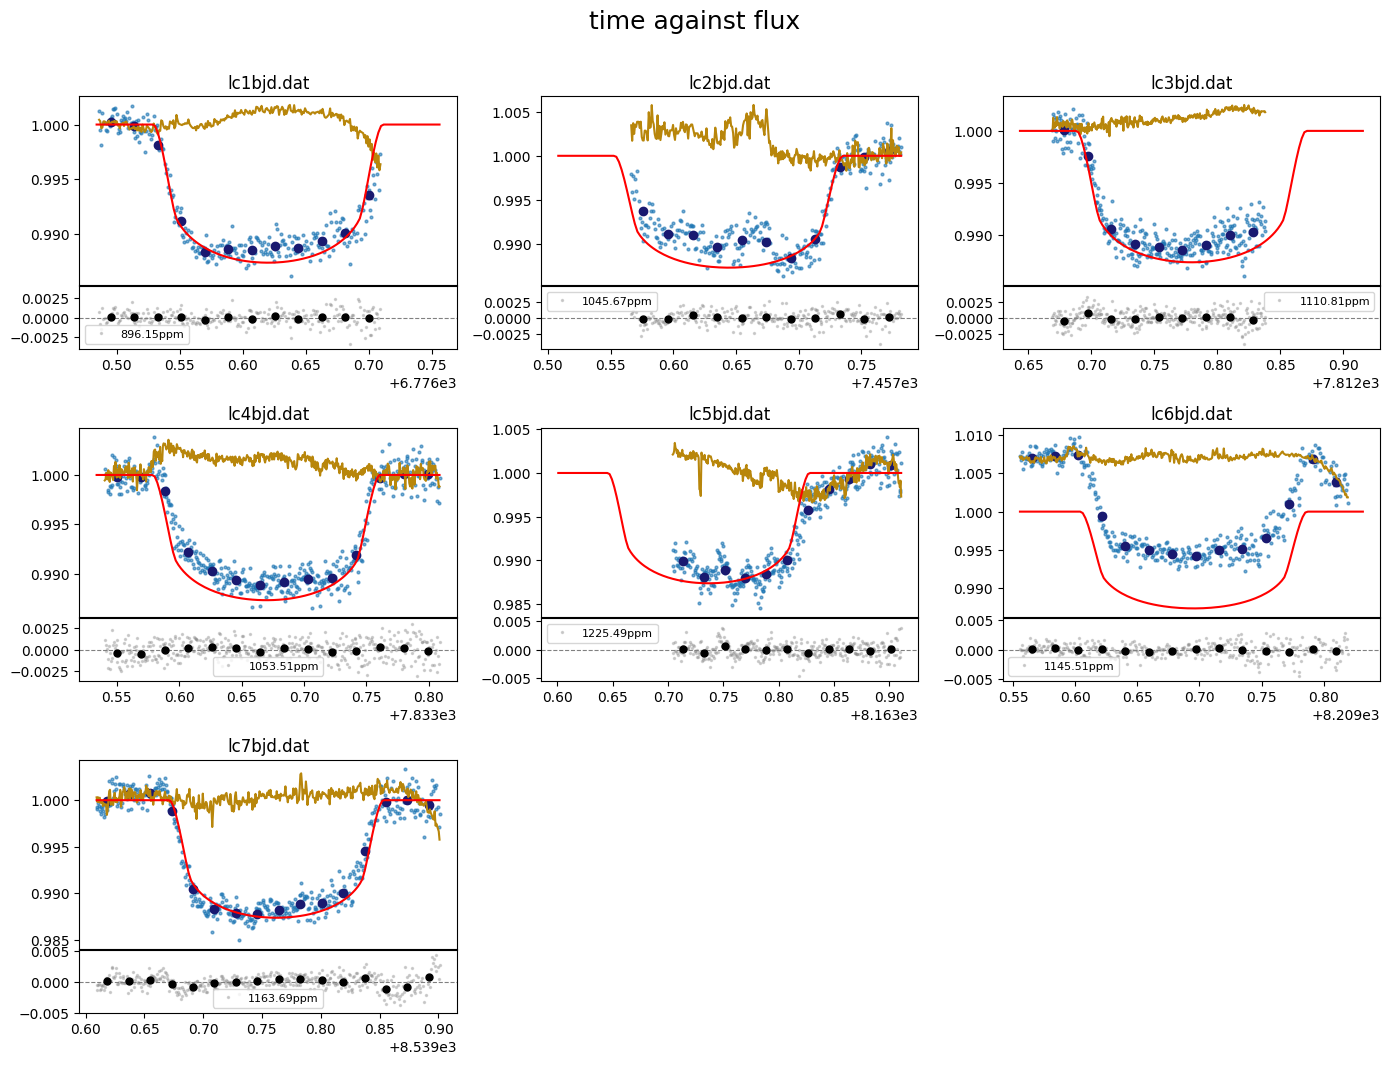

In [9]:
fig = result.lc.plot_bestfit()

##### make plots from results

In [10]:
import pandas as pd
# concatenate output of all LCs
lc_data = pd.concat([result.lc.outdata[nm] for nm in result.lc.outdata.keys()])

In [11]:
#evaluate LC model on a different time array
t_sm  = np.linspace(lc_data["time"].min(), lc_data["time"].max()+0.02, 3000)

lcmod  = result.lc.evaluate(time=t_sm, return_std=True)

phases = phase_fold(t=t_sm, per=result.params.P, 
                    t0=result.params.T0, phase0=-0.5)
#sort
srt    = np.argsort(phases)

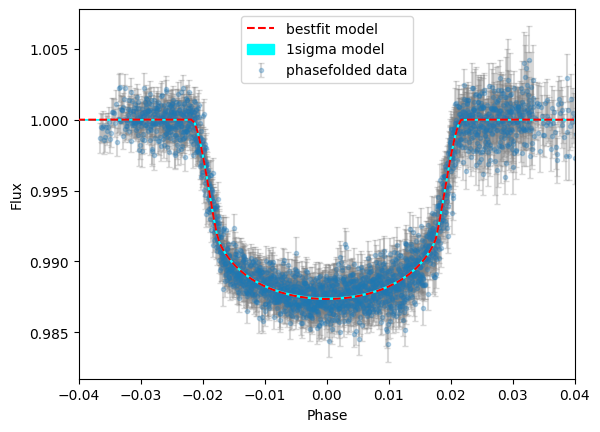

In [12]:

plt.errorbar(lc_data["phase"],lc_data["det_flux"],lc_data["error"],
             fmt="o",ms=3,ecolor="gray",alpha=0.3,capsize=2,label="phasefolded data")

plt.plot(phases[srt], lcmod.planet_model[srt],"r--",zorder=4, label="bestfit model")
plt.fill_between(phases[srt],lcmod.sigma_low[srt], lcmod.sigma_high[srt], color="cyan",
                 zorder=3,label="1sigma model")

plt.xlabel("Phase")
plt.ylabel("Flux")
plt.xlim([-0.04,0.04])
plt.legend();